In [3]:
#import packages
import numpy as np
import numba
from numba import cuda
from numba import njit, jit
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
import scipy

##EllpackMatrix class

To create the EllpackMatrix class I require a method to convert a CSR matrix to ELLPACK and a method to multiply an arbitrary vector of size $N$.  I will use the scipy.sparse.linalg.LinearOperator class and class inheritance to create a new type of linear operator, to do so I must overload the matvec (or @) method and define a shape when initialising the class. 
The shape can be taken from the length of any of the arrays resulting from the transformation from CSR to ellpack.

Below is a GPU kernel of ELLPACK-R on a vector. This will become the "matvec" method on the novel EllpackMatrix Class.

In [33]:
def matvec_ellpack_r_gpu(ell_mat, J, R, x):

  #Define kernel
  @cuda.jit
  def matvec_gpu(d_ell_mat, d_J, d_R, d_x, d_y):

    #Allocate memory
    local_ell_mat = cuda.shared.array((SX), numba.float32)
    local_J = cuda.shared.array((SX), numba.int32)
    local_R = cuda.shared.array((SX), numba.int32)
    local_x = cuda.shared.array((SX), numba.float32)
    local_y = cuda.shared.array((SX), numba.float32)
    

    local_ell_mat = d_ell_mat
    local_J = d_J
    local_R = d_R
    local_x = d_x
    local_y = d_y
    
    #Define local thread location 
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x

    #Define global thread location
    i = cuda.grid(1)

    #Sync threads before operations begin
    cuda.syncthreads()

    if i < N:
      tmp = numba.float32(0)
      for j in range(d_R[i]):
        tmp += local_ell_mat[i,j]*local_x[int(local_J[i,j])]
      local_y[i] = tmp
    cuda.syncthreads()

  #Set parameter values
  Nz = int(max(R))
  N = len(R)
  d_ell_mat = cuda.to_device(ell_mat)
  d_x = cuda.to_device(x)
  d_J = cuda.to_device(J)
  d_R = cuda.to_device(R)

  y = np.zeros(N)
  d_y = cuda.to_device(y)

  SX = 32
  nblocks = (N+SX-1) // SX
  matvec_gpu[(nblocks,1),(SX,Nz)](d_ell_mat, d_J, d_R, d_x, d_y)
  result = d_y.copy_to_host()

  return result

The above function is easily adapted to a method by allowing it to refer to self in which all the required parameters are defined from the composition of the arrays.

In [34]:
class EllpackMatrix(scipy.sparse.linalg.LinearOperator):
  def __init__(self, csr_mat):
    #CSR to ellpack transformation is part of the init method,
    #this way the conversion is done automatically when the class is called.
    
    D = csr_mat.data
    C = csr_mat.indices
    ptr = csr_mat.indptr
    self.ellpack = transform(D,C,ptr)
    self.ell_mat, self.J, self.R = self.ellpack
    self.shape = self.ell_mat.shape
    
  #Define my matvec function using the above kernel
  def matvec(self,x): 
    #Define kernel
    @cuda.jit
    def matvec_gpu(d_ell_mat, d_J, d_R, d_x, d_y):
    ############################################################################
      #Allocate memory
      local_ell_mat = cuda.shared.array((SX), numba.float32)
      local_J = cuda.shared.array((SX), numba.int32)
      local_R = cuda.shared.array((SX), numba.int32)
      local_x = cuda.shared.array((SX), numba.float32)
      local_y = cuda.shared.array((SX), numba.float32)
      

      local_ell_mat = d_ell_mat
      local_J = d_J
      local_R = d_R
      local_x = d_x
      local_y = d_y
      
      #Define local thread location 
      tx = cuda.threadIdx.x
      bx = cuda.blockIdx.x

      #Define global thread location
      i = cuda.grid(1)

      #Sync threads before operations begin
      cuda.syncthreads()

      if i < N:
        tmp = numba.float32(0)
        for j in range(d_R[i]):
          tmp += local_ell_mat[i,j]*local_x[int(local_J[i,j])]
        local_y[i] = tmp
      cuda.syncthreads()

    ############################################################################  
    #Set parameter values
    Nz = int(max(self.R))
    N = len(self.R)
    d_ell_mat = cuda.to_device(self.ell_mat)
    d_x = cuda.to_device(x)
    d_J = cuda.to_device(self.J)
    d_R = cuda.to_device(self.R)

    y = np.zeros(N)
    d_y = cuda.to_device(y)

    SX = 32
    nblocks = (N+SX-1) // SX
    matvec_gpu[(nblocks,1),(SX,int(Nz))](d_ell_mat, d_J, d_R, d_x, d_y)
    result = d_y.copy_to_host()

    return result

  @njit(parallel = True) #use the just-in-tim compiler for the following function.
  def transform(data,col_ind,ptr):
    N = len(ptr)-1
    #Find rl - the length of each row, R - the size of each row in CSR
    rl = np.zeros(N) #Array storing size of each tow including padding.
    R = np.zeros(N) #None 0 row size.

    ##KERNEL 1##
    for k in range(N):
      R[k] = ptr[k+1] - ptr[k]
    Nz = int(max(R))
    ell_mat = np.zeros(shape = (N,Nz))
    J = np.zeros(shape = (N,Nz))
    
    ##KERNEL 2##
    count = 0 #Initiate position in CSR data
    for i in numba.prange(N): #for each pointer value
      for j in range(R[i]):
        ell_mat[i,j] = D[count]
        J[i,j] = C[count]
        count += 1
    return ell_mat, J, R


###Create CSR-> ELLPACK-R and ELLPACK x Vector methods

In this section I document the transformation routine using Numba @njit and its relative error compared to the SciPy CSR_matrix method using several large, randonly chosen vectors. If the product of the matricies in ELLPACK-R and CSR are the same then it stands to reason the the storage schemes for ELLPACK-R is correct.

First we have the CPU parallelised transformation function. The parallelisation is done over the outerloop for the conversion and the loop in which all the needed parameters are defined.

In [ ]:
@njit(nopython=True) #use the just-in-tim compiler for the following function.
def transform(data,col_ind,ptr):
  N = len(ptr)-1
  #Find rl - the length of each row, R - the size of each row in CSR
  rl = np.zeros(N) #Array storing size of each tow including padding.
  R = np.zeros(N) #None 0 row size.

  ##KERNEL 1##
  for k in numba.prange(N): #Find the row lengths
    R[k] = ptr[k+1] - ptr[k] #Row lengths are defined using 
  Nz = int(max(R))

  ell_mat = np.zeros(shape = (N,Nz))
  J = np.zeros(shape = (N,Nz))
  ##KERNEL 2##
  count = 0 #Initiate position in CSR data
  for i in numba.prange(N): #for each pointer value
    for j in range(R[i]):
      ell_mat[i,j] = data[count]
      J[i,j] = col_ind[count]
      count += 1
  return ell_mat, J, R

For the CPU based matvec routine I define a worker which is parallelised over its outer loop. The worker computes the multiplication using parameters passed from the function matvec_cpu, whos function is simply to call the worker. 

In [36]:
#Matvec function for ellpack, I will use a worker
@jit(nopython = True, fastmath = True)
def cpu_matvec_worker(ell_mat, y, R, J, x, N):
  for i in numba.prange(N):
    t = 0
    for j in range(R[i]):
      t += ell_mat[i,j]*x[int(J[i,j])]
    y[i] = t
  return y

def matvec_cpu(ell_mat, J, R, x):
  Nz = max(R)
  N = len(R)
  y = np.zeros(N)
  return cpu_matvec_worker(ell_mat, y, R, J, x, N)

A relative error function that can be used to determin the similarites between two vectors. this can also be used to measure the difference between two matrices after they have both been flattened. 

In [37]:
def err_relative(u,u_exact,N):
  #empty array of lengeth N^2 to store errors
  e_rel = np.zeros(shape=(N)) 
  
  for i in range(N):
    if u_exact[i] != 0:
      e_rel[i]=np.linalg.norm(u[i]-u_exact[i])/np.linalg.norm(u_exact[i])
    else:
        e_rel[i] = np.linalg.norm(u[i]-u_exact[i])
  return e_rel.max()

##Discretise Possion

Below is the discretised possion grid given in the lecture notes. I use this to generate sparse matricies for the purpose of testing and benchmarking the functions I have developed above.

In [6]:
import numpy as np
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

###Compute evolution Ax = u using Ellpack_matrix @ method and and compare with Scipy CSR @ method


In [27]:
N = 100 #Note that due to the size of the poisson problem a dimesnon of N actually requires N^2 by N^2 matricies. 
CSR_P = discretise_poisson(N)[0]
ELL_A, J, R = transform(CSR_P.data, CSR_P.indices, CSR_P.indptr)
x=np.random.rand(N**2)

I now demonstrate the call required in the question statement and print the resulting error.

In [30]:
err_relative(matvec_cpu(ELL_A, J, R,x),CSR_P @ x, N**2)

1.6621093486606947e-12

In [ ]:
my_sparse_mat = EllpackMatrix(CSR_P)
x = np.random.randn(N**2)
y = my_sparse_mat @ x

print('The relative error is :' ,
      err_relative(y, CSR_P @ x, N**2))

I now demonstarate the accuracy of the function of a matrix of dimension $1000000 \times 1000000$ by multiplying it by three random vectorcs of dimension 1000000.

In [ ]:
#Set matrix side length to 100^2 = 10000
N = 100 #Note that due to the size of the poisson problem a dimesnon of N 
        #actually requires N^2 by N^2 matricies. 
CSR_P = discretise_poisson(N)[0]
x=np.random.rand(N**2)
my_sparse_mat = EllpackMatrix(CSR_P)
#Comparison of the GPU kernal from my class against the naive 
#CPU function (not in a class)
my_sparse_mat = EllpackMatrix(CSR_P)
x_1 = np.random.randn(my_sparse_mat.shape[0])
x_2 = np.random.randn(my_sparse_mat.shape[0])
x_3 = np.random.randn(my_sparse_mat.shape[0])
y_1 = my_sparse_mat @ x_1
y_2 = my_sparse_mat @ x_2
y_3 = my_sparse_mat @ x_3
benchmark_1 = CSR_P @ x_1
benchmark_2 = CSR_P @ x_2
benchmark_3 = CSR_P @ x_3

In [40]:
#Print the error values
print('The relative error for the random vector x_1 is :' 
      , err_relative(y_1,benchmark_1,my_sparse_mat.shape[0]))
print('The relative error for the random vector x_2 is :' 
      , err_relative(y_2,benchmark_2,my_sparse_mat.shape[0]))
print('The relative error for the random vector x_3 is :' 
      , err_relative(y_3,benchmark_3,my_sparse_mat.shape[0]))

The relative error for the random vector x_1 is : 1.2068576199804691e-13
The relative error for the random vector x_2 is : 1.466403536310851e-12
The relative error for the random vector x_3 is : 2.1925448882888198e-13


We can see above that all of the errors are of the order of machine precision, meaning that the error is (atleast mostly) due to rounding of the CPU/GPU.

###Testing my GPU implementation using ELLPACK against the SciPy CSR multiplication


To prevent the %timeit magic function from timing the entire cycle and localise it to the GPU kernal I separate the kernal from the matvec function and call it seperatly.

In [17]:
#Define kernel
@cuda.jit
def matvec_gpu(d_ell_mat, d_J, d_R, d_x, d_y):

  #Allocate memory
  local_ell_mat = cuda.shared.array((SX), numba.float32)
  local_J = cuda.shared.array((SX), numba.int32)
  local_R = cuda.shared.array((SX), numba.int32)
  local_x = cuda.shared.array((SX), numba.float32)
  local_y = cuda.shared.array((SX), numba.float32)
  
  #Allocate memory
  local_ell_mat = d_ell_mat
  local_J = d_J
  local_R = d_R
  local_x = d_x
  local_y = d_y
  
  #Define local thread location 
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x

  #Define global thread location
  i = cuda.grid(1)

  #Sync threads before operations begin
  cuda.syncthreads()

  if i < N:
    tmp = numba.float32(0)
    for j in range(d_R[i]):
      tmp += local_ell_mat[i,j]*local_x[int(local_J[i,j])]
    local_y[i] = tmp
  cuda.syncthreads()
  

I will consider row and column sizes of $2500$ to $1000000$

In [18]:
dim = np.arange(50,1050,50)

In [ ]:
#Assign parameters and call the kernel.
GPU_ELLR_recorder = []
for N in dim:
  CSR_P = discretise_poisson(N)[0]
  ELL_A, J, R = transform(CSR_P.data, CSR_P.indices, CSR_P.indptr)
  x = np.random.randn(N**2)

  Nz = int(max(R))
  d_ell_mat = cuda.to_device(ELL_A)
  d_x = cuda.to_device(x)
  d_J = cuda.to_device(J)
  d_R = cuda.to_device(R)

  y = np.zeros(N**2)
  d_y = cuda.to_device(y)

  SX = 32
  nblocks = (N**2+SX-1) // SX
  #Initialise kernel
  a = %timeit -o matvec_gpu[(nblocks,1),(SX,Nz)](d_ell_mat, d_J, d_R, d_x, d_y)
  GPU_ELLR_recorder.append(a.best)
  result = d_y.copy_to_host()

In [ ]:
CPU_recorder = []
for N in dim:
  x = np.random.rand(N**2)
  CSR_P = discretise_poisson(N)[0]
  a,b,c = transform(CSR_P.data,CSR_P.indices,CSR_P.indptr)
  p = %timeit -o matvec_cpu(a,b,c,x)
  CPU_recorder.append(p.best)

In [ ]:
CSR_recorder = []
for N in dim:
  x = np.random.rand(N**2)
  CSR_P = discretise_poisson(N)[0]
  a = %timeit -o CSR_P @ x
  CSR_recorder.append(a.best)

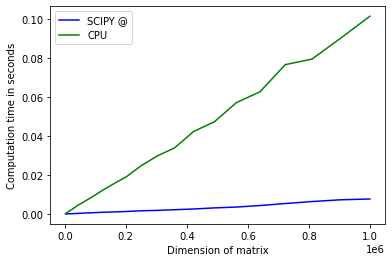

In [14]:
#Plot the results using matplotlib
#plt.plot(dim**2,GPU_ELLR_recorder,'-r',label = 'ELLPACK GPU')
plt.plot(dim**2,CSR_recorder,'-b',label = 'SCIPY @')
plt.plot(dim**2,CPU_recorder,'-g',label = 'CPU')
plt.xlabel('Dimension of matrix')
plt.ylabel('Computation time in seconds')
plt.legend(loc="best")
plt.show()

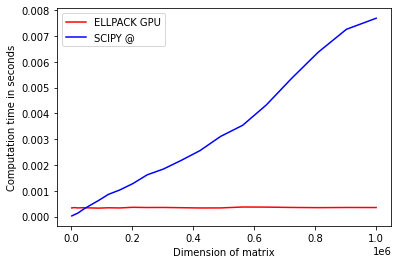

In [20]:
#Plot the results using matplotlib
plt.plot(dim**2,GPU_ELLR_recorder,'-r',label = 'ELLPACK GPU')
plt.plot(dim**2,CSR_recorder,'-b',label = 'SCIPY @')
#plt.plot(dim**2,CPU_recorder,'-g',label = 'CPU')
plt.xlabel('Dimension of matrix')
plt.ylabel('Computation time in seconds')
plt.legend(loc="best")
plt.show()

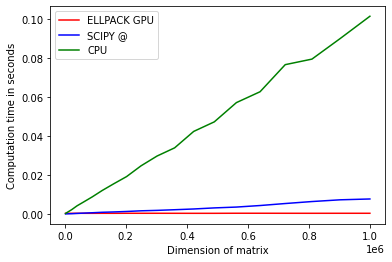

In [21]:
#Plot the results using matplotlib
plt.plot(dim**2,GPU_ELLR_recorder,'-r',label = 'ELLPACK GPU')
plt.plot(dim**2,CSR_recorder,'-b',label = 'SCIPY @')
plt.plot(dim**2,CPU_recorder,'-g',label = 'CPU')
plt.xlabel('Dimension of matrix')
plt.ylabel('Computation time in seconds')
plt.legend(loc="best")
plt.show()

As we can see, on the domain size (up to 1000000 by 1000000) the GPU implementation is far superior to both the CPU implementation and to the numpy CSR "@" method. Testing at higher dimensions is limited due to the amount of time taken for the discretise_poisson function to run.

The time taken by the GPU remains constant on the given domain, which given the structure of ellpack R makes sense. Since each new dimension introduces a new thread which has no dependence on any others, the additional time will to compute will come almost exclusivly from the setup.

There is not matrix architecture where this isnt true, but Ellpack R still has its problem, as I will demonstrate.

##Matrix Market

From the matrix market I want to demonstarate a matrix well suited to ELLPACK R and one which is a poor candidate for ELLPACK R.

The good candidate is a matrix such that each of the rows has roughly the sanme number of non-zero elements. Correspondingly a matrix with a huge difference in the number of elements in each row would be a bad candidate. This is becasue the speed up from reducing the row lengths is lost.

A good way to over come this would be to assign more threads to rows with more non-zero elements. Due to a lack of time I will bot be making this improvement but it is worth rembering. 

In [22]:
from scipy.io import mminfo,mmread #Import package to read in matrix market products.

first = mmread("/content/gemat11.mtx")
second = mmread("/content/bcspwr10.mtx")
mminfo('/content/bcspwr10.mtx'), mminfo('/content/gemat11.mtx')


((5300, 5300, 13571, 'coordinate', 'pattern', 'symmetric'),
 (4929, 4929, 33185, 'coordinate', 'real', 'general'))

In [23]:
CSR_first = first.tocsr()
ELL_first, J_first, R_first = transform(CSR_first.data, 
                                        CSR_first.indices, 
                                        CSR_first.indptr)

CSR_second = second.tocsr()
ELL_second, J_second, R_second = transform(CSR_second.data, 
                                           CSR_second.indices, 
                                           CSR_second.indptr)

N_f = ELL_first.shape[0]
N_s = ELL_second.shape[0]
x_f = np.random.randn(N_f)
x_s = np.random.randn(N_s)
#View the shape of ELL_A and CSR_large_row_diff
print('1st dimensions (Dense, ELLPACK R) :', 
      CSR_first.todense().shape, 
      ELL_first.shape,
      '2st dimensions (Dense, ELLPACK R) ', 
      CSR_second.todense().shape, 
      ELL_second.shape)

1st dimensions (Dense, ELLPACK R) : (4929, 4929) (4929, 27) 2st dimensions (Dense, ELLPACK R)  (5300, 5300) (5300, 14)


Both of these matrices reduce to a tiny column size when stored in the Ellpack format. This provides a huge speed up due to the reduction in useless computations.

In [24]:
Nz = int(max(R))
d_ell_mat = cuda.to_device(ELL_first)
d_x = cuda.to_device(x_f)
d_J = cuda.to_device(J_first)
d_R = cuda.to_device(R_first)

y = np.zeros(N_f)
d_y = cuda.to_device(y)

SX = 32
nblocks = (N+SX-1) // SX
first_GPU_time = %timeit -o matvec_gpu[(nblocks,1),(SX,Nz)](d_ell_mat, d_J, d_R, d_x, d_y)
result = d_y.copy_to_host()

CSR_first_time = %timeit -o CSR_first @ x_f

CPU_first_time = %timeit -o matvec_cpu(ELL_first, J_first, R_first, x_f)

1000 loops, best of 5: 344 µs per loop
The slowest run took 5.41 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 62 µs per loop
1000 loops, best of 5: 558 µs per loop


In [25]:
Nz = int(max(R))
d_ell_mat = cuda.to_device(ELL_second)
d_x = cuda.to_device(x_s)
d_J = cuda.to_device(J_second)
d_R = cuda.to_device(R_second)

y = np.zeros(N)
d_y = cuda.to_device(y)

SX = 32
nblocks = (N+SX-1) // SX
second_GPU_time = %timeit -o matvec_gpu[(nblocks,1),(SX,Nz)](d_ell_mat, d_J, d_R, d_x, d_y)
result = d_y.copy_to_host()

CSR_second_time = %timeit -o CSR_second @ x_s

CPU_second_time = %timeit -o matvec_cpu(ELL_second, J_second, R_second, x_s)

1000 loops, best of 5: 343 µs per loop
10000 loops, best of 5: 47.6 µs per loop
1000 loops, best of 5: 599 µs per loop


For the first amd second examples I achive the following results.

In [26]:
print('The GPU version took (first,second):', first_GPU_time.best,'|', second_GPU_time.best)
print('The CPU version took (first,second):', CPU_first_time.best,'|',CPU_second_time.best)
print('The SciPy CSR version took (first,second):', CSR_first_time.best,'|',CSR_second_time.best)

The GPU version took (first,second): 0.000344456753002305 | 0.00034299369499785824
The CPU version took (first,second): 0.0005577351070023724 | 0.0005991854579988285
The SciPy CSR version took (first,second): 6.199259040004108e-05 | 4.76470503002929e-05


The SciPy version is the clear winner, but the GPU implementation shaved a significant amount of time from the parallel jit implementation. Unfortunatly we cannot see the advantage ELLPACK R has here due to the size of the matrices. Before we require matrices with 100's of 1000's of rows before ELLPACK R became superior, and I was unable to find suitable matrices on the matrix market. We can however clearly see the benefit of GPU implementations over CPU implementations.